In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [1]:
import time
import wandb

wandb.login(key='5fba6eb84f8afe69955c7e841ccdd1cc1c634560')
run=wandb.init(project='Template_detection',name='face_clustering')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\csadh\_netrc
wandb: Currently logged in as: tanu-adhikari-ug23 (tanu-adhikari-ug23-plaksha-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [78]:
## Reading the image plaksha_Faculty.jpg
img = cv2.imread("Plaksha_Faculty.jpg")

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Detect faces in the image (using defined min and max sizes)
faces_rect = face_cascade.detectMultiScale(gray_img, scaleFactor=1.05, minNeighbors=4, minSize=(25,25), maxSize=(50,50))

# Annotate faces with rectangles and text
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(img, "Face", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Log annotated image to WandB (convert BGR to RGB)
img_r = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
run.log({"Face_Detected":wandb.Image(img_r, caption="Total number of face detected are "+str(len(faces_rect)))})
cv2.waitKey(0)
cv2.destroyAllWindows()

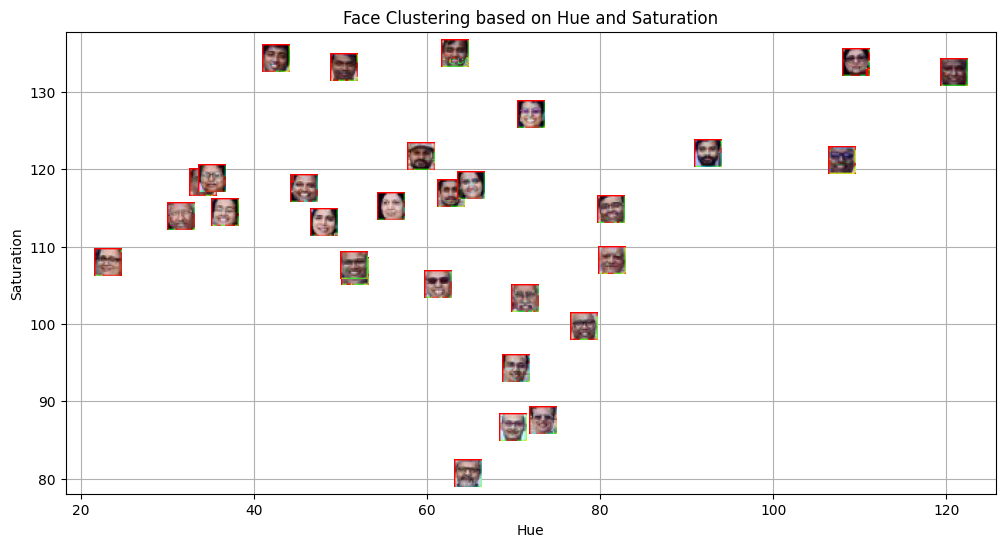

In [79]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) ## call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(hue_saturation)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])

wandb.log({"Face Clustering based on Hue and Saturation": wandb.Image(fig)})
    

## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Face Clustering based on Hue and Saturation")
## Put grid
plt.grid(True)
## show the plot
plt.show()

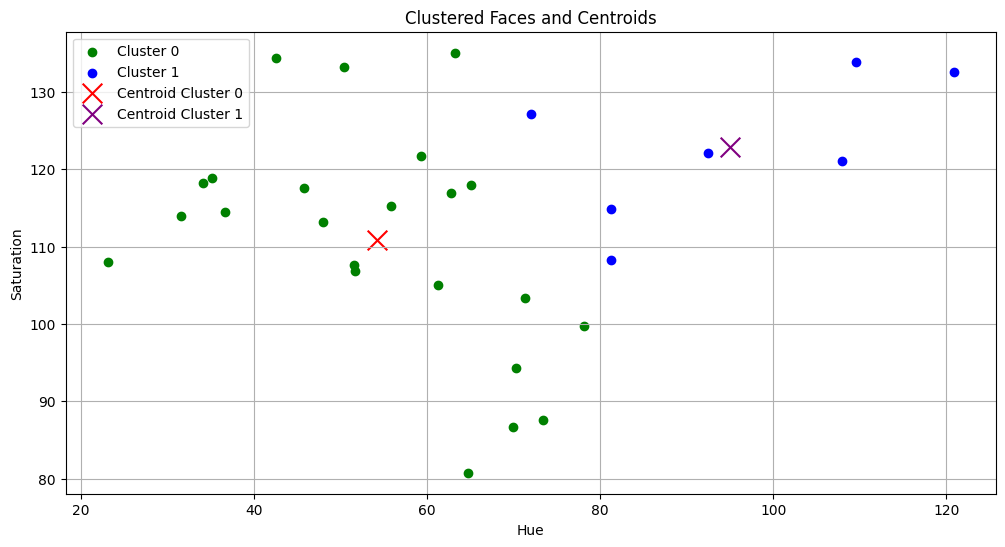

In [80]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig1, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')


cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')

# Calculate and plot centroids
centroid_0 = np.mean(cluster_0_points, axis=0) if len(cluster_0_points) > 0 else None
centroid_1 = np.mean(cluster_1_points, axis=0) if len(cluster_1_points) > 0 else None

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], color='red', marker='x', s=200, label='Centroid Cluster 0')
plt.scatter(centroid_1[0], centroid_1[1], color='purple', marker='x', s=200, label='Centroid Cluster 1')

wandb.log({"clusters_centroids": wandb.Image(fig1)})

## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Clustered Faces and Centroids")
## Add a legend
plt.legend()
## Add grid
plt.grid(True)
## Show the plot
plt.show()


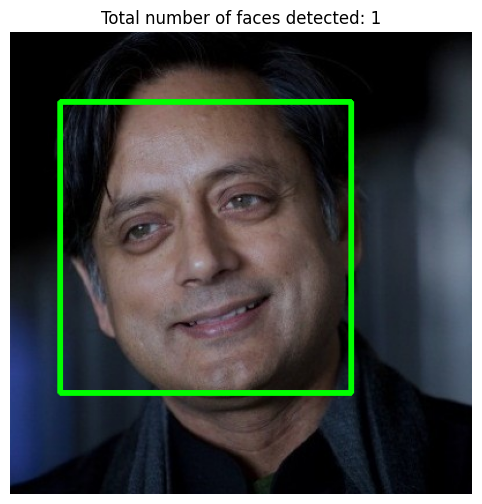

In [81]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img_path = "./Dr_Shashi_Tharoor.jpg"
template_img = cv2.imread(template_img_path)  # Read the image
# Detect face  in the template image after converting it to gray and store it in template_faces
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
template_faces = face_cascade.detectMultiScale(template_gray, 1.1, 4)
# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
# Convert BGR to RGB for displaying in matplotlib
img_rgb = cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB)
wandb.log({"template_detection": wandb.Image(img_rgb)})

# Display image using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Total number of faces detected: {len(template_faces)}")
plt.savefig("shashi_tharoor_face.png")
plt.show()

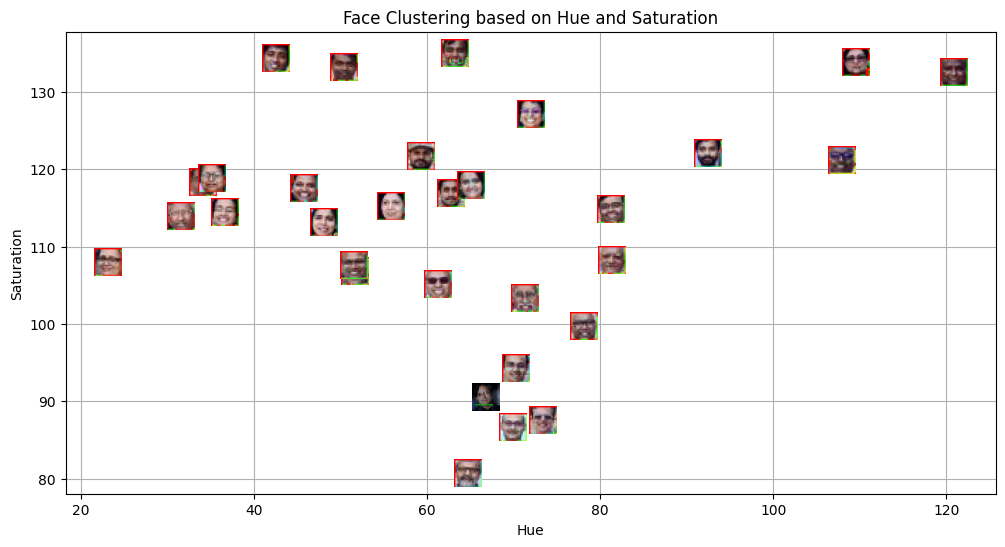

In [82]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig2, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)
wandb.log({"template_classification": wandb.Image(fig2)})
## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Face Clustering based on Hue and Saturation")
## Add grid
plt.grid(True)
## show plot
plt.show()

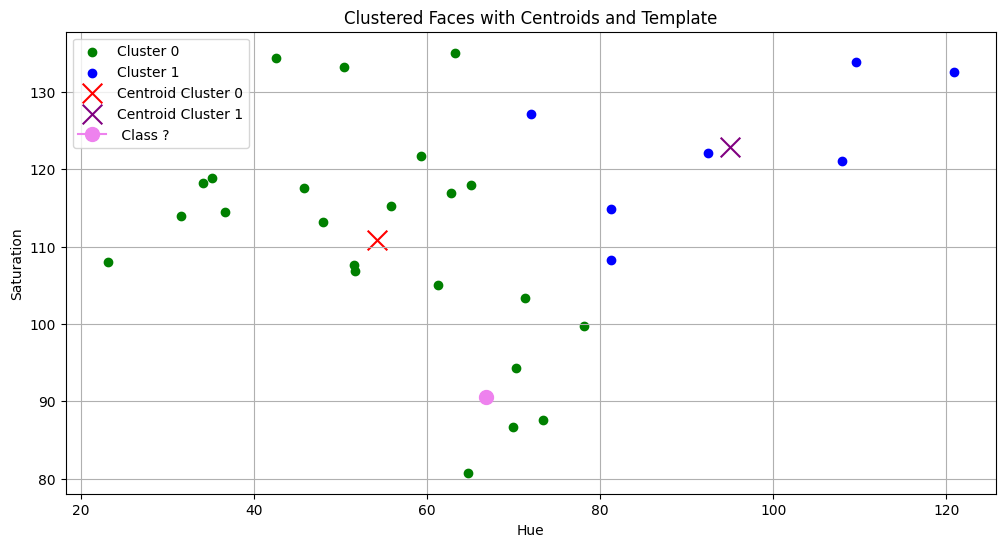

In [83]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')


# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')

# Calculate and plot centroids for both the clusters
centroid_0 = np.mean(cluster_0_points, axis=0) if len(cluster_0_points) > 0 else None
centroid_1 = np.mean(cluster_1_points, axis=0) if len(cluster_1_points) > 0 else None
plt.scatter(centroid_0[0], centroid_0[1], color='red', marker='x', s=200, label='Centroid Cluster 0') ## plot for centroid 0
plt.scatter(centroid_1[0], centroid_1[1], color='purple', marker='x', s=200, label='Centroid Cluster 1')  ## plot for centroid 1
plt.plot(template_hue, template_saturation, marker='o', c= 'violet',markersize= 10, label=' Class ?' )

## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Clustered Faces with Centroids and Template")
## Add a legend
plt.legend()
## Add grid
plt.grid(True)
## show the plot
plt.show()
                                            ## End of the lab 5 ##